<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/HW/hw6/nn_hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ## *[NN HW6](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/05-NN/05-nlp/01-tfidf-word2vec/Home%20-%20LSTM%20Sentiment%20Analysis.ipynb "Задание 1. Применить модель на Embdedding слое и LSTM для оценки тональности отзыва с IMDB")*

### Задание 1. Применить модель на Embdedding слое и LSTM для оценки тональности отзыва с IMDB
(Безлайн accuracy 0.85)

\* *Там сейчас [проблема](https://github.com/tensorflow/tensorflow/issues/28102 "The Keras examples should load data with allow_pickle=True #28102") с `numpy 1.16.3`, поэтому явно установим предыдущую версию.*

In [1]:
!pip install numpy==1.16.2

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
np.__version__

'1.16.2'

### *Загрузка датасета*

In [4]:
from keras.datasets import imdb

Using TensorFlow backend.


In [0]:
vocabulary_size = 5000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)

In [6]:
print('Review')
print(X_train[5])
print('Label')
print(y_train[5])

Review
[1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
Label
0


In [7]:
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('Review with words')
print([id2word.get(i, ' ') for i in X_train[5]])
print('Label')
print(y_train[5])

Review with words
['the', 'effort', 'still', 'been', 'that', 'usually', 'makes', 'for', 'of', 'finished', 'and', 'ended', 'and', 'an', 'because', 'before', 'if', 'just', 'though', 'something', 'know', 'novel', 'female', 'i', 'i', 'slowly', 'lot', 'of', 'above', 'and', 'with', 'connect', 'in', 'of', 'script', 'their', 'that', 'out', 'end', 'his', 'and', 'i', 'i']
Label
0


In [8]:
[ x.shape for x in (X_train, y_train, X_test, y_test) ]

[(25000,), (25000,), (25000,), (25000,)]

In [9]:
np.unique(y_train)

array([0, 1])

Два класса, следовательно на последнем слое будем использовать сигмоидальную активацию.

In [10]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras.layers as L

import tensorflow as tf
tf.__version__

'1.13.1'

### *Распределение текстов по длине* 

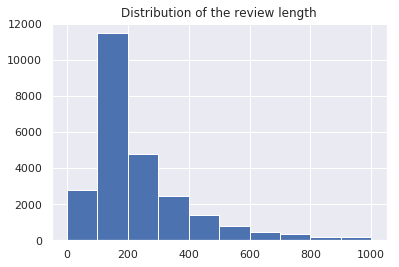

In [11]:
plt.hist([ len(x) for x in X_train ], range=(0, 1000))
plt.title('Distribution of the review length');

Ограничим длину последовательностей:

In [0]:
MAX_SEQUENCE_LENGTH = 700

X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
[ x.shape for x in (X_train, y_train, X_test, y_test) ]

[(25000, 700), (25000,), (25000, 700), (25000,)]

###  *Модель*

Embdedding +  LSTM + sigmoid


In [14]:
MAX_NB_WORDS = vocabulary_size
EMBEDDING_DIM = 100

model = Sequential()
model.add(L.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(L.SpatialDropout1D(0.2))
model.add(L.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(L.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 100)          500000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 700, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 580,501
Trainable params: 580,501
Non-trainable params: 0
_________________________________________________________________
None


Несмотря на *dropout*, всё равно быстро переобучается, так что большое число эпох не имеет смысла.

In [15]:
epochs = 2
batch_size = 75

# callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 390s 17ms/step - loss: 0.4941 - acc: 0.7557 - val_loss: 0.4278 - val_acc: 0.7952
Epoch 2/2
22500/22500 [==============================] - 384s 17ms/step - loss: 0.3658 - acc: 0.8481 - val_loss: 0.3532 - val_acc: 0.8588


In [16]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 149s 6ms/step
Test score: 0.3482943890839815
Test accuracy: 0.8559999995827675


### *Вывод*

Модель обучается достаточно долго, есть склонность к переобучению. На требуемый *baseline* выйти удалось, но существенно превысить его -- нет.